In [36]:
# load data

import scipy.io

mat = scipy.io.loadmat('Xtrain.mat')

mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Apr 29 11:11:31 2019',
 '__version__': '1.0',
 '__globals__': [],
 'Xtrain': array([[ 86],
        [141],
        [ 95],
        [ 41],
        [ 22],
        [ 21],
        [ 32],
        [ 72],
        [138],
        [111],
        [ 48],
        [ 23],
        [ 19],
        [ 27],
        [ 59],
        [129],
        [129],
        [ 58],
        [ 27],
        [ 19],
        [ 24],
        [ 46],
        [112],
        [144],
        [ 73],
        [ 30],
        [ 20],
        [ 19],
        [ 37],
        [ 92],
        [152],
        [ 93],
        [ 36],
        [ 20],
        [ 18],
        [ 29],
        [ 71],
        [146],
        [117],
        [ 46],
        [ 23],
        [ 18],
        [ 22],
        [ 52],
        [128],
        [142],
        [ 62],
        [ 26],
        [ 17],
        [ 19],
        [ 37],
        [100],
        [158],
        [ 86],
        [ 32],
        [ 17],
        [ 1

In [37]:
data = mat['Xtrain']
data

array([[ 86],
       [141],
       [ 95],
       [ 41],
       [ 22],
       [ 21],
       [ 32],
       [ 72],
       [138],
       [111],
       [ 48],
       [ 23],
       [ 19],
       [ 27],
       [ 59],
       [129],
       [129],
       [ 58],
       [ 27],
       [ 19],
       [ 24],
       [ 46],
       [112],
       [144],
       [ 73],
       [ 30],
       [ 20],
       [ 19],
       [ 37],
       [ 92],
       [152],
       [ 93],
       [ 36],
       [ 20],
       [ 18],
       [ 29],
       [ 71],
       [146],
       [117],
       [ 46],
       [ 23],
       [ 18],
       [ 22],
       [ 52],
       [128],
       [142],
       [ 62],
       [ 26],
       [ 17],
       [ 19],
       [ 37],
       [100],
       [158],
       [ 86],
       [ 32],
       [ 17],
       [ 17],
       [ 27],
       [ 72],
       [154],
       [118],
       [ 43],
       [ 20],
       [ 15],
       [ 21],
       [ 47],
       [128],
       [150],
       [ 63],
       [ 24],
       [ 16],
      

In [ ]:
# scale data
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data


array([[0.33201581],
       [0.54940711],
       [0.36758893],
       [0.1541502 ],
       [0.07905138],
       [0.07509881],
       [0.11857708],
       [0.27667984],
       [0.53754941],
       [0.43083004],
       [0.18181818],
       [0.08300395],
       [0.06719368],
       [0.09881423],
       [0.22529644],
       [0.50197628],
       [0.50197628],
       [0.22134387],
       [0.09881423],
       [0.06719368],
       [0.08695652],
       [0.17391304],
       [0.43478261],
       [0.56126482],
       [0.28063241],
       [0.11067194],
       [0.07114625],
       [0.06719368],
       [0.13833992],
       [0.35573123],
       [0.59288538],
       [0.35968379],
       [0.13438735],
       [0.07114625],
       [0.06324111],
       [0.10671937],
       [0.27272727],
       [0.56916996],
       [0.45454545],
       [0.17391304],
       [0.08300395],
       [0.06324111],
       [0.07905138],
       [0.19762846],
       [0.49802372],
       [0.55335968],
       [0.23715415],
       [0.094

In [39]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 20
X, y = create_sequences(scaled_data, n_steps)

## Using cross-validation

In [40]:
n_samples = len(scaled_data)

cv_n_splits = 5

# n_steps_candidates = [i for i in range(10, 101, 10)] # steps of 10 up to 100, this returns that the best candidate is 10
n_steps_candidates = [i for i in range(1, 11, 1)] # steps of 1 up to 10

min_train_fold_size = n_samples // (cv_n_splits + 1)

print(f"Smallest training fold will have approx {min_train_fold_size} samples.")
print(f"Testing n_steps candidates: {n_steps_candidates}")

Smallest training fold will have approx 166 samples.
Testing n_steps candidates: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [69]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout



tscv = TimeSeriesSplit(n_splits=cv_n_splits)
results_mae = {} # Store average MSE for each n_steps

# Perform Cross-Validation
for n_steps_candidate in n_steps_candidates:
    print(f"\nEvaluating n_steps = {n_steps_candidate}")
    fold_mses = []
    fold_idx = 0

    for train_index, test_index in tscv.split(scaled_data):
        fold_idx += 1
        print(f"  Fold {fold_idx}/{cv_n_splits}")
        
        # Prepare training data for the current fold
        train_data_fold = scaled_data[train_index]
        X_train_fold, y_train_fold = create_sequences(train_data_fold, n_steps_candidate)

        # Reshape X_train_fold if it's not empty
        X_train_fold = X_train_fold.reshape((X_train_fold.shape[0], n_steps_candidate, 1))

        # Define and compile the model (fresh for each fold for simplicity)
        # For faster CV, you could potentially reset weights if architecture is fixed.
        model_cv = Sequential([
            SimpleRNN(50, activation='tanh', input_shape=(n_steps_candidate, 1)),
            Dropout(0.2),
            Dense(1)
        ])
        model_cv.compile(optimizer='adam', loss='mse')

        # Train the model
        # print(f"    Training on {X_train_fold.shape[0]} sequences...")
        model_cv.fit(X_train_fold, y_train_fold, epochs=100, verbose=0) # Reduced epochs for CV speed

        # Prepare test data and predict
        # We predict one step ahead for each point in the test set
        y_pred_fold = []
        y_true_fold = []

        for i in range(len(test_index)):
            current_test_point_idx = test_index[i]
            
            # Input sequence for prediction ends at the point before current_test_point_idx and has length n_steps_candidate
            start_idx_for_test_input = current_test_point_idx - n_steps_candidate
            
            input_seq_test = scaled_data[start_idx_for_test_input:current_test_point_idx].reshape(1, n_steps_candidate, 1)
            
            pred_scaled = model_cv.predict(input_seq_test, verbose=0)
            y_pred_fold.append(pred_scaled[0,0])
            y_true_fold.append(scaled_data[current_test_point_idx, 0])
            
        fold_mse = mean_squared_error(y_true_fold, y_pred_fold)
        fold_mses.append(fold_mse)
        print(f"    Fold {fold_idx} MSE: {fold_mse:.6f} for {len(y_true_fold)} test points")

    if fold_mses:
        avg_mse_for_n_steps = np.mean(fold_mses)
        results_mae[n_steps_candidate] = avg_mse_for_n_steps
        print(f"  Average MSE for n_steps = {n_steps_candidate}: {avg_mse_for_n_steps:.6f}")
    else:
        print(f"  No valid MSE calculated for n_steps = {n_steps_candidate} across folds.")
        results_mae[n_steps_candidate] = float('inf') # Assign high error if no results


# Determine the best n_steps

# Filter out inf values before finding min
valid_results = {k: v for k, v in results_mae.items() if v != float('inf')}

best_n_steps = min(valid_results, key=valid_results.get)
print(f"\n--- Cross-Validation Results ---")
for n_s, mse_val in results_mae.items():
    print(f"n_steps = {n_s}, Average MSE = {mse_val:.6f}")
print(f"\nBest n_steps based on Time Series Cross-Validation: {best_n_steps} (MSE: {valid_results[best_n_steps]:.6f})")



Evaluating n_steps = 1
  Fold 1/5
    Fold 1 MSE: 0.014643 for 166 test points
  Fold 2/5


KeyboardInterrupt: 


 Training final model with best_n_steps = 20
Final model trained.

First 10 future predictions (original scale) using best_n_steps=20:
[ 63.37339  170.021    123.66022   41.63377   19.043777   9.211805
  14.443328  20.788446  86.95061  183.07704 ]


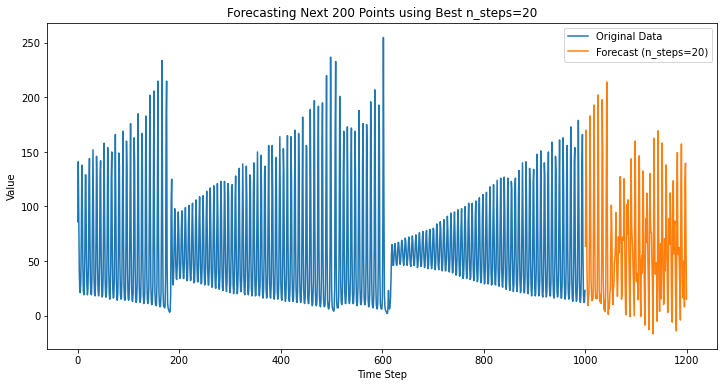

In [77]:
best_n_steps = 20 # insert value found above or test with another one
# Train Final Model with Best n_steps and Make Future Predictions
print(f"\n Training final model with best_n_steps = {best_n_steps}")
X_final, y_final = create_sequences(scaled_data, best_n_steps)

if X_final.shape[0] > 0:
    X_final_reshaped = X_final.reshape((X_final.shape[0], best_n_steps, 1))

    final_model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=(best_n_steps, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    final_model.compile(optimizer='adam', loss='mse')
    final_model.fit(X_final_reshaped, y_final, epochs=500, verbose=0)
    print("Final model trained.")

    # Example of making future predictions
    n_future = 200
    input_seq_future = scaled_data[-best_n_steps:].reshape(1, best_n_steps, 1)
    predictions_scaled_future = []

    for _ in range(n_future):
        next_pred_scaled = final_model.predict(input_seq_future, verbose=0)
        predictions_scaled_future.append(next_pred_scaled[0])
        next_input_reshaped = next_pred_scaled.reshape((1, 1, 1))
        input_seq_future = np.append(input_seq_future[:, 1:, :], next_input_reshaped, axis=1)
    
    predictions_future_original_scale = scaler.inverse_transform(np.array(predictions_scaled_future).reshape(-1,1))
    print(f"\nFirst 10 future predictions (original scale) using best_n_steps={best_n_steps}:")
    print(predictions_future_original_scale[:10].flatten())
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.plot(range(len(data)), data, label="Original Data")
    plt.plot(range(len(data), len(data) + n_future), predictions_future_original_scale, label=f"Forecast (n_steps={best_n_steps})")
    plt.legend()
    plt.title(f"Forecasting Next {n_future} Points using Best n_steps={best_n_steps}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.show()

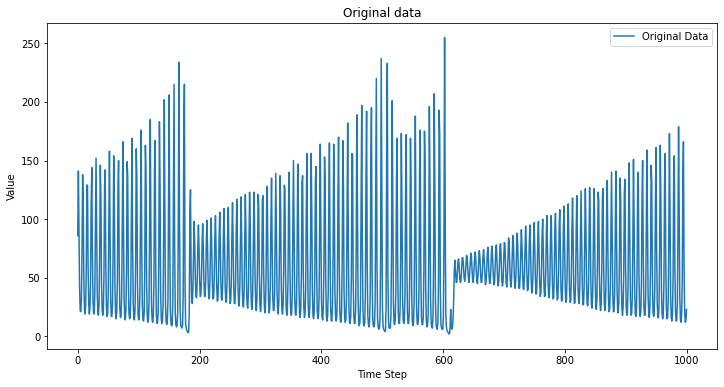

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(range(len(data)), data, label="Original Data")
plt.legend()
plt.title(f"Original data")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()

## Not using cross-validation 

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(n_steps, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=500, verbose=0)


In [80]:
n_future = 200
input_seq = scaled_data[-n_steps:].reshape(1, n_steps, 1)  # Start from last known input
predictions_scaled = []

for i in range(n_future):
    next_pred = model.predict(input_seq, verbose=0)  # shape (1, 1)
    predictions_scaled.append(next_pred[0])

    # Correctly reshape to 3D shape: (1, 1, 1)
    next_input = next_pred.reshape((1, 1, 1))

    # Append new prediction to last n-1 steps
    input_seq = np.append(input_seq[:, 1:, :], next_input, axis=1)


In [81]:
predictions = scaler.inverse_transform(predictions_scaled)
predictions

array([[ 75.56427321],
       [174.87050128],
       [105.70608979],
       [ 32.43417772],
       [ 24.13922817],
       [ 22.10496591],
       [ 18.81715056],
       [ 33.77834073],
       [124.38183221],
       [165.56908214],
       [ 56.01029189],
       [ 18.62368956],
       [ 25.07924972],
       [ 28.30136916],
       [ 22.65496653],
       [ 69.58722705],
       [170.40574288],
       [110.55953455],
       [ 29.5286831 ],
       [ 17.6140136 ],
       [ 30.12445521],
       [ 28.92576119],
       [ 29.82550036],
       [117.98912916],
       [163.76352656],
       [ 59.56757131],
       [ 18.31813534],
       [ 25.06853917],
       [ 33.19794264],
       [ 28.01018427],
       [ 66.86498994],
       [163.85602713],
       [117.67333186],
       [ 33.73903477],
       [ 17.14081906],
       [ 30.73230828],
       [ 30.91492866],
       [ 30.82050917],
       [112.86020342],
       [162.43139172],
       [ 63.70015933],
       [ 18.96126235],
       [ 24.14936568],
       [ 33

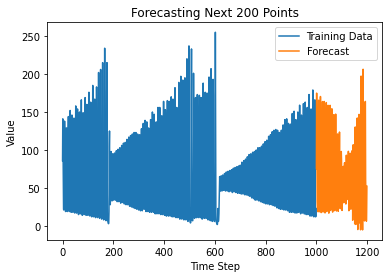

In [82]:
import matplotlib.pyplot as plt

plt.plot(range(len(data)), data, label="Training Data")
plt.plot(range(len(data), len(data) + n_future), predictions, label="Forecast")
plt.legend()
plt.title("Forecasting Next 200 Points")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()


## Testing

In [83]:
test_mat = scipy.io.loadmat('Xtest.mat')

test_mat = test_mat['Xtest']
test_mat

array([[ 72],
       [178],
       [122],
       [ 36],
       [ 14],
       [ 11],
       [ 14],
       [ 32],
       [110],
       [188],
       [ 80],
       [ 23],
       [ 12],
       [ 10],
       [ 15],
       [ 45],
       [151],
       [169],
       [ 53],
       [ 18],
       [ 12],
       [  9],
       [ 17],
       [ 60],
       [182],
       [143],
       [ 38],
       [ 13],
       [  9],
       [  9],
       [ 19],
       [ 71],
       [201],
       [126],
       [ 30],
       [ 12],
       [  9],
       [  8],
       [ 18],
       [ 70],
       [211],
       [131],
       [ 30],
       [ 11],
       [  8],
       [  8],
       [ 13],
       [ 47],
       [192],
       [179],
       [ 40],
       [ 13],
       [  9],
       [  7],
       [  7],
       [ 14],
       [ 71],
       [255],
       [131],
       [ 24],
       [  9],
       [  7],
       [  7],
       [  5],
       [  4],
       [  3],
       [  8],
       [ 20],
       [ 13],
       [ 10],
       [ 13],
      

In [84]:
# calculate MSE and MAE
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_200 = test_mat.reshape(-1, 1)

mae = mean_absolute_error(actual_200, predictions)
mse = mean_squared_error(actual_200, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")


MAE: 38.78
MSE: 2974.47


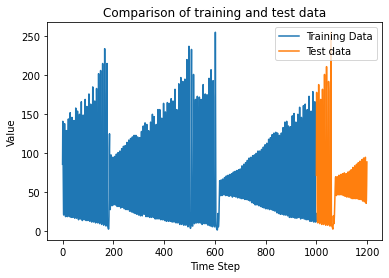

In [85]:
import matplotlib.pyplot as plt

plt.plot(range(len(data)), data, label="Training Data")
plt.plot(range(len(data), len(data) + n_future), actual_200, label="Test data")
plt.legend()
plt.title("Comparison of training and test data")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()